# 案例介绍
SVC在现实中的应用十分广泛，尤其实在图像和文字识别方面，但SVC真实应用的代码其实就是sklearn中的三行，真正能够展现出SVM强大之处的，反而很少是案例本身，而是之前所作的各种探索。

在实际工作中，数据预处理往往比建模难得多，耗时多得多，因此合理的数据预处理是非常必要的。**本案例数据集是未经过预处理的澳大利亚天气数据集。本文的目标是在这个数据集上来预测明天是否会下雨。这个案例的核心目的，是通过巧妙的预处理和特征工程来展示如何在现实数据集上做数据预处理，或者有哪些预处理的方式和思路**。

预测天气是一个非常困难的主题，因为影响天气的因素太多，而Kaggle的这份数据也是一份非常难的数据集，难到大部分算法在这个数据集上都不会有太好的结果，尤其是召回率recall，异常地低。**在这里因为支持向量机运行较慢，故在15W行原数据集上只随机抽样5000个样本来展示数据预处理和特征工程的过程，提供一些数据预处理和特征工程的思路**。不过，特征工程没有标准答案，因此大家应当多尝试，希望使用原数据集的伙伴们可以到Kaggle下载最原始版本。

**完整数据集下载链接走这里：https://www.kaggle.com/jsphyg/weather-dataset-rattle-package**

# 1  导库导数据，探索特征
- **导入需要的库**

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder  # 用于标签编码
from math import radians  # 用于将角度转换为弧度
import re
from sklearn.impute import SimpleImputer  # 用于填补缺失值
from sklearn.preprocessing import OrdinalEncoder  # 用于特征编码
from sklearn.preprocessing import StandardScaler  # 用于特征缩放，无量纲化
from time import time
import datetime
from sklearn.svm import SVC  # 支持向量机分类器
from sklearn.metrics import roc_auc_score, recall_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

- **导入数据，探索数据**

In [26]:
weather = pd.read_csv('weatherAUS5000.csv', index_col=0)
weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
0,2015-03-24,Adelaide,12.3,19.3,0.0,5.0,NaN,S,39.0,S,...,19.0,59.0,47.0,1022.2,1021.4,NaN,NaN,15.1,17.7,No
1,2011-07-12,Adelaide,7.9,11.4,0.0,1.0,0.5,N,20.0,NNE,...,7.0,70.0,59.0,1028.7,1025.7,NaN,NaN,8.4,11.3,No
2,2010-02-08,Adelaide,24.0,38.1,0.0,23.4,13.0,SE,39.0,NNE,...,19.0,36.0,24.0,1018.0,1016.0,NaN,NaN,32.4,37.4,No
3,2016-09-19,Adelaide,6.7,16.4,0.4,NaN,NaN,N,31.0,N,...,15.0,65.0,40.0,1014.4,1010.0,NaN,NaN,11.2,15.9,No
4,2014-03-05,Adelaide,16.7,24.8,0.0,6.6,11.7,S,37.0,S,...,24.0,61.0,48.0,1019.3,1018.9,NaN,NaN,20.8,23.7,No


来查看一下各个特征都代表了什么：
# 截图

In [27]:
# 将特征矩阵和标签分开
X = weather.iloc[:, :-1]
Y = weather.iloc[:, -1]

X.shape, Y.shape

((5000, 21), (5000,))

In [28]:
# 查看数据基本信息
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           5000 non-null   object 
 1   Location       5000 non-null   object 
 2   MinTemp        4979 non-null   float64
 3   MaxTemp        4987 non-null   float64
 4   Rainfall       4950 non-null   float64
 5   Evaporation    2841 non-null   float64
 6   Sunshine       2571 non-null   float64
 7   WindGustDir    4669 non-null   object 
 8   WindGustSpeed  4669 non-null   float64
 9   WindDir9am     4651 non-null   object 
 10  WindDir3pm     4887 non-null   object 
 11  WindSpeed9am   4949 non-null   float64
 12  WindSpeed3pm   4919 non-null   float64
 13  Humidity9am    4936 non-null   float64
 14  Humidity3pm    4880 non-null   float64
 15  Pressure9am    4506 non-null   float64
 16  Pressure3pm    4504 non-null   float64
 17  Cloud9am       3111 non-null   float64
 18  Cloud3pm

In [29]:
# 探索缺失值
X.isnull().mean()  # 即缺失值所占总值的比例：isnull().sum(全部的True)/X.shape[0]
# 针对不同缺失情况要有不同的缺失值填补策略！

Date             0.0000
Location         0.0000
MinTemp          0.0042
MaxTemp          0.0026
Rainfall         0.0100
Evaporation      0.4318
Sunshine         0.4858
WindGustDir      0.0662
WindGustSpeed    0.0662
WindDir9am       0.0698
WindDir3pm       0.0226
WindSpeed9am     0.0102
WindSpeed3pm     0.0162
Humidity9am      0.0128
Humidity3pm      0.0240
Pressure9am      0.0988
Pressure3pm      0.0992
Cloud9am         0.3778
Cloud3pm         0.3976
Temp9am          0.0066
Temp3pm          0.0176
dtype: float64

In [30]:
Y.isnull().sum()  # 0 故标签无缺失值
# 探索标签的分类，是一个二分类问题
# np.unique(Y)
Y.value_counts()

No     3861
Yes    1139
Name: RainTomorrow, dtype: int64

粗略观察可以发现，这个特征矩阵由一部分分类变量和一部分连续变量组成，大多数特征都是采集的自然数据，比如蒸发量，日照时间，湿度等等，而少部分特征是人为构成的。还有一些是单纯表示样本信息的变量，比如采集信息的地点，以及采集的时间。

# 2 分集，优先探索标签
- **分训练集和测试集，并做描述性统计**


In [35]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=420)

# 重置索引
for i in [Xtrain, Xtest, Ytrain, Ytest]:
    i.index = range(i.shape[0])

在现实中，我们会先分训练集和测试集，再开始进行数据预处理。这是由于，测试集在现实中往往是不可获得的，或者被假设为是不可获得的，我们不希望我们建模的任何过程受到测试集数据的影响，否则的话，就相当于提前告诉了模型一部分预测的答案。如果先进行预处理，再分训练集和测试集，这是一种不规范的做法。在这里，为了让案例尽量接近真实的样貌，所以采取了现实中所使用的这种方式：**先分训练集和测试集，再一步步进行预处理。这样导致的结果是，我们对训练集执行的所有操作，都必须对测试集执行一次，工作量是翻倍的**。

In [36]:
# 是否有样本不均衡问题
Ytrain.value_counts()  # 有轻微的样本不均衡问题
Ytest.value_counts()

# 将二分类标签编码成0 1
# 使用训练集的标签来训练编码器，然后对训练集和测试集的标签分别进行编码
encoder = LabelEncoder().fit(Ytrain)
Ytrain = pd.DataFrame(encoder.transform(Ytrain))
Ytest = pd.DataFrame(encoder.transform(Ytest))

# 由于现实情况中数据处理的复杂性，可以将处理后的数据保存下来，以便后续使用
# Ytrain.to_csv('Ytrain.csv', index=False)

# 3 探索特征，开始处理特征矩阵
## 3.1 描述性统计与异常值

In [ ]:
# 描述性统计可以:1.查看数据是否有异常值；2.查看数据是否有偏态分布 3. 查看量纲是否统一
Xtrain.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T
Xtest.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

In [47]:
# 对于去kaggle上下载了数据的小伙伴们，以及对于坚持要使用完整版数据的（15W行）数据的小伙伴们
# 如果你发现了异常值，首先你要观察，这个异常值出现的频率
# 如果异常值只出现了一次，多半是输入错误，直接把异常值删除
# 如果异常值出现了多次，去跟业务人员沟通，人为造成的错误异常值留着是没有用的
# 如果异常值占到你总数据量的10%左右了 - 把异常值替换成非异常但是非干扰的项，比如说用0来进行替换，或者把异常当缺失

# 下面是对于完整数据集处理异常值的步骤

# 查看原始的数据结构
Xtrain.shape
Xtest.shape

#观察异常值是大量存在，还是少数存在
Xtrain.loc[Xtrain.loc[:, "Cloud9am"] == 9, "Cloud9am"]
Xtest.loc[Xtest.loc[:, "Cloud9am"] == 9, "Cloud9am"]
Xtest.loc[Xtest.loc[:, "Cloud3pm"] == 9, "Cloud3pm"]

#少数存在，于是采取删除的策略
#注意如果删除特征矩阵，则必须连对应的标签一起删除，特征矩阵的行和标签的行必须要一一对应
Xtrain = Xtrain.drop(index=71737)
Ytrain = Ytrain.drop(index=71737)

#删除完毕之后，观察原始的数据结构，确认删除正确
Xtrain.shape

Xtest = Xtest.drop(index=[19646, 29632])
Ytest = Ytest.drop(index=[19646, 29632])
Xtest.shape

#进行任何行删除之后，千万记得要恢复索引
for i in [Xtrain, Xtest, Ytrain, Ytest]:
    i.index = range(i.shape[0])
Xtrain.head()
Xtest.head()

## 3.2 处理困难特征：日期
我们采集数据的日期是否和我们的天气有关系呢？我们可以探索一下我们的采集日期有什么样的性质：

In [59]:
Xtrain.iloc[:, 0].value_counts()  # 该结果显示日期有重复

Xtrainc = Xtrain.copy()
Xtrainc.sort_values(by="Date")

# 首先，日期不是独一无二的，日期有重复
# 其次，在我们分训练集和测试集之后，日期也不是连续的，而是分散的
# 某一年的某一天倾向于会下雨？或者倾向于不会下雨吗？
# 不是日期影响了下雨与否，反而更多的是这一天的日照时间，湿度，温度等等这些因素影响了是否会下雨
# 光看日期，其实感觉它对我们的判断并无直接影响
# 如果我们把它当作连续型变量处理，那算法会人为它是一系列1~3000左右的数字，不会意识到这是日期

Xtrain.iloc[:, 0].value_counts().count()
# 如果我们把它当作分类型变量处理，类别太多，有2141类，如果换成数值型，会被直接当成连续型变量，如果做成哑
# 变量，我们特征的维度会爆炸

如果我们的思考简单一些，我们可以直接删除日期这个特征。首先它不是一个直接影响我们标签的特征，并且要处理日期其实是非常困难的。如果认可这种思路，那可以直接运行下面的代码来删除日期：

In [ ]:
Xtrain = Xtrain.drop(["Date"], axis=1)
Xtest = Xtest.drop(["Date"], axis=1)

但在这里，很多人可能会持不同意见，怎么能够随便删除一个特征（哪怕我们已经觉得它可能无关）？如果我们要删除，我们可能需要一些统计过程，来判断说这个特征确实是和标签无关的，那我们可以先将“日期”这个特征编码后对它和标签做方差齐性检验（ANOVA），如果检验结果表示日期这个特征的确和我们的标签无关，那我们就可以愉快地删除这个特征了。但要编码“日期”这个特征，就又回到了它到底是否会被算法当成是分类变量的问题上。

其实我们可以想到，日期必然是和我们的结果有关的，它会从两个角度来影响我们的标签：首先，我们可以想到，昨天的天气可能会影响今天的天气，而今天的天气又可能会影响明天的天气。也就是说，随着日期的逐渐改变，样本是会受到上一个样本的影响的。但是对于算法来说，**普通的算法是无法捕捉到样本与样本之间的联系的，我们的算法捕捉的是样本的每个特征与标签之间的联系（即列与列之间的联系），而无法捕捉样本与样本之间的联系（行与行的联系）**。

要让算法理解上一个样本的标签可能会影响下一个样本的标签，我们必须使用时间序列分析。时间序列分析是指将同一统计指标的数值按其发生的时间先后顺序排列而成的数列。时间序列分析的主要目的是根据已有的历史数据对未来进行预测。然而，（据我所知）时间序列只能在单调的，唯一的时间上运行，即一次只能够对一个地点进行预测，不能够实现一次性预测多个地点，除非进行循环。而我们的时间数据本身，不是单调的，也不是唯一的，经过抽样之后，甚至连连续的都不是了，我们的时间是每个混杂在多个地点中，每个地点上的一小段时间。如何使用时间序列来处理这个问题，就会变得复杂。

那我们可以换一种思路，既然算法处理的是列与列之间的关系，我是否可以把”今天的天气会影响明天的天气“这个指标转换成一个特征呢？我们就这样来操作。

我们观察到，我们的特征中有一列叫做“Rainfall"，这是表示当前日期当前地区下的降雨量，换句话说，也就是”今天的降雨量“。凭常识我们认为，今天是否下雨，应该会影响明天是否下雨，比如有的地方可能就有这样的气候，一旦下雨就连着下很多天，也有可能有的地方的气候就是一场暴雨来得快去的快。==因此，我们可以将时间对气候的连续影响，转换为”今天是否下雨“这个特征，巧妙地将样本对应标签之间的联系，转换成是特征与标签之间的联系了==。

In [64]:
Xtrain["Rainfall"].head(20)

# 如果今天的降雨量大于1，那么我们就认为今天下雨了，我们就可以将今天是否下雨这个特征构建出来了
Xtrain.loc[Xtrain["Rainfall"] >= 1, "RainToday"] = "Yes"
Xtrain.loc[Xtrain["Rainfall"] < 1, "RainToday"] = "No"
Xtrain.loc[Xtrain["Rainfall"] == np.nan, "RainToday"] = np.nan

# 同样的，我们也要对测试集进行同样的操作
Xtest.loc[Xtest["Rainfall"] >= 1, "RainToday"] = "Yes"
Xtest.loc[Xtest["Rainfall"] < 1, "RainToday"] = "No"
Xtest.loc[Xtest["Rainfall"] == np.nan, "RainToday"] = np.nan

Xtrain.head()

Xtest.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,2016-01-23,NorahHead,22.0,27.8,25.2,NaN,NaN,SSW,57.0,S,...,37.0,91.0,86.0,1006.6,1008.1,NaN,NaN,26.2,23.1,Yes
1,2009-03-05,MountGambier,12.0,18.6,2.2,3.0,7.8,SW,52.0,SW,...,28.0,88.0,62.0,1020.2,1019.9,8.0,7.0,14.8,17.5,Yes
2,2010-03-05,MountGinini,9.1,13.3,NaN,NaN,NaN,NE,41.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-10-26,Wollongong,13.1,20.3,0.0,NaN,NaN,SW,33.0,W,...,24.0,40.0,51.0,1021.3,1019.5,NaN,NaN,16.8,19.6,No
4,2016-11-28,Sale,12.2,20.0,0.4,NaN,NaN,E,33.0,SW,...,19.0,92.0,69.0,1015.6,1013.2,8.0,4.0,13.6,19.0,No


如此，我们就创造了一个特征，今天是否下雨“RainToday”。那现在，我们是否就可以将日期删除了呢？

对于我们而言，日期本身并不影响天气，但是日期所在的月份和季节其实是影响天气的，如果任选梅雨季节的某一天，那明天下雨的可能性必然比非梅雨季节的那一天要大。虽然我们无法让机器学习体会不同月份是什么季节，但是我们可以对不同月份进行分组，算法可以通过训练感受到，“这个月或者这个季节更容易下雨”。因此，我们可以将月份或者季节提取出来，作为一个特征使用，而舍弃掉具体的日期。**如此，我们又可以创造第二个特征，月份"Month"**。

In [66]:
Xtrain["Date"] = Xtrain["Date"].apply(lambda x: int(x.split("-")[1]))
# apply是对dataframe上的某一列进行处理的一个函数
# lambda x匿名函数：在dataframe上这一列中的每一行帮我执行冒号后的命令

#替换完毕后，我们需要修改列的名称
#rename是比较少有的，可以用来修改单个列名的函数
#我们通常都直接使用 df.columns = 某个列表 这样的形式来一次修改所有的列名
#但rename允许我们只修改某个单独的列

Xtrain.rename(columns={"Date": "Month"}, inplace=True)

# 同样的，我们也要对测试集进行同样的操作
Xtest["Date"] = Xtest["Date"].apply(lambda x: int(x.split("-")[1]))
Xtest.rename(columns={"Date": "Month"}, inplace=True)

Xtest.head()

,Month,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,1,NorahHead,22.0,27.8,25.2,NaN,NaN,SSW,57.0,S,...,37.0,91.0,86.0,1006.6,1008.1,NaN,NaN,26.2,23.1,Yes
1,3,MountGambier,12.0,18.6,2.2,3.0,7.8,SW,52.0,SW,...,28.0,88.0,62.0,1020.2,1019.9,8.0,7.0,14.8,17.5,Yes
2,3,MountGinini,9.1,13.3,NaN,NaN,NaN,NE,41.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,Wollongong,13.1,20.3,0.0,NaN,NaN,SW,33.0,W,...,24.0,40.0,51.0,1021.3,1019.5,NaN,NaN,16.8,19.6,No
4,11,Sale,12.2,20.0,0.4,NaN,NaN,E,33.0,SW,...,19.0,92.0,69.0,1015.6,1013.2,8.0,4.0,13.6,19.0,No


通过时间，我们处理出两个新特征，“今天是否下雨”和“月份”。接下来，让我们来看看如何处理另一个更加困难的特征，地点。

## 3.3 处理困难特征：地点
地点，又是一个非常tricky的特征。常识上来说，我们认为地点肯定是对明天是否会下雨存在影响的。比如说，如果其他信息都不给出，我们只猜测，“伦敦明天是否会下雨”和”北京明天是否会下雨“，我一定会猜测伦敦会下雨，而北京不会，因为伦敦是常年下雨的城市，而北京的气候非常干燥。对澳大利亚这样面积巨大的国家来说，必然存在着不同的城市有着不同的下雨倾向的情况。

但尴尬的是，和时间一样，我们输入地点的名字对于算法来说，就是一串字符，"London"和"Beijing"对算法来说，和0，1没有区别。同样，我们的样本中含有49个不同地点，如果做成分类型变量，算法就无法辨别它究竟是否是分类变量。也就是说，我们需要让算法意识到，不同的地点因为气候不同，所以对“明天是否会下雨”有着不同的影响。如果我们能够将地点转换为这个地方的气候的话，我们就可以将不同城市打包到同一个气候中，而同一个气候下反应的降雨情况应该是相似的。

那我们如何将城市转换为气候呢？在google找到了如下地图：
# 截图
这是由澳大利亚气象局和澳大利亚建筑规范委员会（ABCB）制作统计的，澳大利亚不同地区不同城市的所在的气候区域划分。总共划分为八个区域，非常适合我们用来做分类。如果能够把49个地点转换成八种不同的气候，这个信息应该会对是否下雨的判断比较有用。

**文件Cityclimate.csv存储了澳大利亚主要城市所对应的气候类型数据。文件cityll.csv存储了每个澳大利亚主要城市所对应的经纬度，文件samplecity存储了我们训练集中气象站地点对应的经纬度**。

为什么我们会需要城市的经纬度呢？因为样本中的地点名称，其实是气候站的名称，而不是城市本身的名称，因此不是每一个城市都能够直接获取到城市的气候。比如说，如果我们搜索“海淀区气候”，搜索引擎返回的可能是海淀区现在的气温，而不是整个北京的气候类型。因此，我们需要澳大利亚气象局的数据，来找到这些气候站所对应的城市。

我们有了澳大利亚全国主要城市的气候，也有了澳大利亚主要城市的经纬度（地点），我们就可以通过计算我们样本中的每个气候站到各个主要城市的地理距离，来找出一个离这个气象站最近的主要城市，而这个主要城市的气候就是我们样本点所在的地点的气候。

让我们把cityll.csv和Cityclimate.csv来导入，来看看它们是什么样子：

In [74]:
cityll = pd.read_csv('cityll.csv', index_col=0)
cityll.head()  # 每个主要城市对应的经纬度

,City,Latitude,Longitude,Latitudedir,Longitudedir
0,Adelaide,34.9285°,138.6007°,"S,",E
1,Albany,35.0275°,117.8840°,"S,",E
2,Albury,36.0737°,146.9135°,"S,",E
3,Wodonga,36.1241°,146.8818°,"S,",E
4,AliceSprings,23.6980°,133.8807°,"S,",E


In [75]:
city_climate = pd.read_csv('Cityclimate.csv')
city_climate.head()  # 澳大利亚统计局做的每个城市对应的气候

,City,Climate
0,Adelaide,Warm temperate
1,Albany,Mild temperate
2,Albury,"Hot dry summer, cool winter"
3,Wodonga,"Hot dry summer, cool winter"
4,AliceSprings,"Hot dry summer, warm winter"


接下来，我们来将这两张表处理成可以使用的样子，首先要去掉cityll中经纬度上带有的度数符号，然后要将两张表合并起来。

In [84]:
# 去掉度数符号
cityll['Latitudenum'] = cityll['Latitude'].apply(lambda x: float(x[:-1]))
cityll['Longitudenum'] = cityll['Longitude'].apply(lambda x: float(x[:-1]))

# 观察一下所有城市的经纬度分布，全部是南纬，东经，因为澳大利亚在南半球，东半球
# 所以经纬度的方向可以舍弃了
citylld = cityll.iloc[:, [0, 5, 6]]

# 合并两张表
citylld["climate"] = city_climate.iloc[:, -1]

citylld.head()

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_6228/4073847663.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citylld["climate"] = city_climate.iloc[:, -1]


,City,Latitudenum,Longitudenum,climate
0,Adelaide,34.9285,138.6007,Warm temperate
1,Albany,35.0275,117.8840,Mild temperate
2,Albury,36.0737,146.9135,"Hot dry summer, cool winter"
3,Wodonga,36.1241,146.8818,"Hot dry summer, cool winter"
4,AliceSprings,23.6980,133.8807,"Hot dry summer, warm winter"


In [85]:
# 查看有哪几种气候类型
citylld.loc[:, "climate"].value_counts()

Hot dry summer, cool winter          24
Warm temperate                       18
Hot dry summer, warm winter          18
High humidity summer, warm winter    17
Mild temperate                        9
Cool temperate                        9
Warm humid summer, mild winter        5
Name: climate, dtype: int64

接下来，我们如果想要计算距离，我们就会需要所有样本数据中的城市。通常我们假设，只有出现在训练集中的地点才会出现在测试集中。

In [94]:
samplecity = pd.read_csv('samplecity.csv', index_col=0)
# 我们对samplecity进行处理，去掉经纬度的度数符号，并且舍弃经纬度的方向
samplecity['Latitudenum'] = samplecity['Latitude'].apply(lambda x: float(x[:-1]))
samplecity['Longitudenum'] = samplecity['Longitude'].apply(lambda x: float(x[:-1]))
samplecityd = samplecity.iloc[:, [0, 5, 6]]
samplecityd.head()

,City,Latitudenum,Longitudenum
0,Canberra,35.2809,149.1300
1,Sydney,33.8688,151.2093
2,Perth,31.9505,115.8605
3,Darwin,12.4634,130.8456
4,Hobart,42.8821,147.3272


好了，我们现在有了澳大利亚主要城市的经纬度和对应的气候，也有了我们的样本的地点所对应的经纬度，**接下来我们要开始计算我们样本上的地点到每个澳大利亚主要城市的距离，而离我们的样本地点最近的那个澳大利亚主要城市的气候，就是我们样本点的气候**。

在地理上，两个地点之间的距离，由如下公式来进行计算：
$$dist=R \times arccos[sin(slat) \times sin(elat) + cos(slat) \times cos(elat) \times cos(slon - elon)]$$

其中R是地球的半径，6371.01km，arccos是三角反余弦函数，slat是起始地点的纬度，slon是起始地点的经度，elat是结束地点的纬度，elon是结束地点的经度。本质还是计算两点之间的距离。而我们的经纬度，本质其实是角度，所以需要用各种三角函数和弧度公式将角度转换成距离。

In [97]:
# 首先使用radians将角度转换为弧度
citylld.loc[:, "slat"] = citylld.iloc[:, 1].apply(lambda x: radians(x))
citylld.loc[:, "slon"] = citylld.iloc[:, 2].apply(lambda x: radians(x))
samplecityd.loc[:, "elat"] = samplecityd.iloc[:, 1].apply(lambda x: radians(x))
samplecityd.loc[:, "elon"] = samplecityd.iloc[:, 2].apply(lambda x: radians(x))

for i in range(samplecityd.shape[0]):
    slat = citylld.loc[:, "slat"]
    slon = citylld.loc[:, "slon"]
    elat = samplecityd.loc[i, "elat"]
    elon = samplecityd.loc[i, "elon"]
    dist = 6371.01 * np.arccos(np.sin(slat) * np.sin(elat) +
                               np.cos(slat) * np.cos(elat) * np.cos(slon.values - elon))
    city_index = np.argsort(dist)[0]  # 将dist中的元素从小到大排列，提取其对应的index(索引)，然后取最小的那个index
    #每次计算后，取距离最近的城市，然后将最近的城市和城市对应的气候都匹配到samplecityd中
    samplecityd.loc[i, "closest_city"] = citylld.loc[city_index, "City"]
    samplecityd.loc[i, "climate"] = citylld.loc[city_index, "climate"]

D:\ANACONDA\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
D:\ANACONDA\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
D:\ANACONDA\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [102]:
# 查看最后的结果，需要检查城市是否匹配正确
samplecityd.head(5)

,City,Latitudenum,Longitudenum,elat,elon,closest_city,climate
0,Canberra,35.2809,149.1300,0.615768,2.602810,Canberra,Cool temperate
1,Sydney,33.8688,151.2093,0.591122,2.639100,Sydney,Warm temperate
2,Perth,31.9505,115.8605,0.557641,2.022147,Perth,Warm temperate
3,Darwin,12.4634,130.8456,0.217527,2.283687,Darwin,"High humidity summer, warm winter"
4,Hobart,42.8821,147.3272,0.748434,2.571345,Hobart,Cool temperate


In [103]:
# 查看气候的分布
samplecityd.loc[:, "climate"].value_counts()

Warm temperate                       15
Mild temperate                       10
Cool temperate                        9
Hot dry summer, cool winter           6
High humidity summer, warm winter     4
Hot dry summer, warm winter           3
Warm humid summer, mild winter        2
Name: climate, dtype: int64

In [107]:
# 确认无误后，取出样本城市和对应的气候，并保存
locafinal = samplecityd.iloc[:, [0, -1]]
locafinal.columns = ["location", "climate"]

# 在这里设定location为索引，是为了之后进行map的匹配
locafinal = locafinal.set_index("location")
locafinal.to_csv("samplelocation.csv")
locafinal.head()

,climate
location,
Canberra,Cool temperate
Sydney,Warm temperate
Perth,Warm temperate
Darwin,"High humidity summer, warm winter"
Hobart,Cool temperate


有了每个样本城市所对应的气候，我们接下来就使用气候来替掉原本的城市，即原本的气象站的名称。在这里，我们可以使用map功能，map能够将特征中的值一一对应到我们设定的字典中，并且用字典中的值来替换样本中原本的值，在之前评分卡案例中曾经使用这个功能来用WOE替换我们原本的特征的值。

In [108]:
# 还记得训练集不？
Xtrain.head()

,Month,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8,Katherine,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN,No
1,12,Tuggeranong,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6,No
2,4,Albany,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8,No
3,11,Sale,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5,No
4,4,Mildura,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4,No


In [112]:
#将location中的内容替换，并且确保匹配进入的气候字符串中不含有逗号，气候两边不含有空格
#我们使用re这个模块来消除逗号
#re.sub(希望替换的值，希望被替换成的值，要操作的字符串)
#x.strip()是去掉空格的函数
Xtrain["Location"] = Xtrain["Location"].map(locafinal.iloc[:, 0]).apply(lambda x: re.sub(",", "", x.strip()))
Xtest["Location"] = Xtest["Location"].map(locafinal.iloc[:, 0]).apply(lambda x: re.sub(",", "", x.strip()))

# 修改特征内容后，我们使用新列名"Climate"来替换原本的"Location"
Xtrain.rename(columns={"Location": "Climate"}, inplace=True)
Xtest.rename(columns={"Location": "Climate"}, inplace=True)

Xtrain.head()

,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8,High humidity summer warm winter,17.5,36.0,0.0,8.8,NaN,ESE,26.0,NNW,...,15.0,57.0,NaN,1016.8,1012.2,0.0,NaN,27.5,NaN,No
1,12,Cool temperate,9.5,25.0,0.0,NaN,NaN,NNW,33.0,NE,...,17.0,59.0,31.0,1020.4,1017.5,NaN,NaN,14.6,23.6,No
2,4,Mild temperate,13.0,22.6,0.0,3.8,10.4,NaN,NaN,NE,...,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8,No
3,11,Mild temperate,13.9,29.8,0.0,5.8,5.1,S,37.0,N,...,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5,No
4,4,Hot dry summer cool winter,6.0,23.5,0.0,2.8,8.6,NNE,24.0,E,...,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4,No


到这里，地点就处理完毕了。其实，我们还没有将这个特征转化为数字，即还没有对它进行编码。我们稍后和其他的分类型变量一起来编码。
## 3.4 处理分类型变量：缺失值
接下来，我们总算可以开始处理我们的缺失值了。首先我们要注意到，由于我们的特征矩阵由两种类型的数据组成：分类型和连续型，因此我们必须对两种数据采用不同的填补缺失值策略。**传统地，如果是分类型特征，我们则采用众数进行填补。如果是连续型特征，我们则采用均值来填补**。

此时，由于我们已经分了训练集和测试集，我们需要考虑一件事：**究竟使用哪一部分的数据进行众数填补呢？答案是使用训练集上的众数对训练集和测试集都进行填补**。为什么会这样呢？按道理说就算用测试集上的众数对测试集进行填补，也不会使测试集数据进入我们建好的模型，不会给模型透露一些信息。然而，在现实中，我们的测试集未必是很多条数据，也许我们的测试集只有一条数据，而某个特征上是空值，此时此刻测试集本身的众数根本不存在，要如何利用测试集本身的众数去进行填补呢？因此为了避免这种尴尬的情况发生，我们假设测试集和训练集的数据分布和性质都是相似的，因此我们统一使用训练集的众数和均值来对测试集进行填补。

在sklearn当中，即便是我们的填补缺失值的类也需要由实例化，fit和接口调用执行填补三个步骤来进行，而这种分割其实一部分也是为了满足我们使用训练集的建模结果来填补测试集的需求。我们只需要实例化后，使用训练集进行fit，然后在调用接口执行填补时用训练集fit后的结果分别来填补测试集和训练集就可以了。

In [114]:
# 查看缺失值的情况
Xtrain.isnull().mean()

Month            0.000000
Climate          0.000000
MinTemp          0.004000
MaxTemp          0.003143
Rainfall         0.009429
Evaporation      0.433429
Sunshine         0.488571
WindGustDir      0.067714
WindGustSpeed    0.067714
WindDir9am       0.067429
WindDir3pm       0.024286
WindSpeed9am     0.009714
WindSpeed3pm     0.018000
Humidity9am      0.011714
Humidity3pm      0.026286
Pressure9am      0.098857
Pressure3pm      0.098857
Cloud9am         0.379714
Cloud3pm         0.401429
Temp9am          0.005429
Temp3pm          0.019714
RainToday        0.009429
dtype: float64

In [118]:
# 首先找出分类型特征
cate = Xtrain.columns[
    Xtrain.dtypes == "object"].tolist()  # ['Climate','WindGustDir','WindDir9am','WindDir3pm', 'RainToday']

# 除了特征类型为object的，还有虽然是数字，但是实际上是分类型特征的云层遮蔽程度
cloud = ["Cloud9am", "Cloud3pm"]
cate = cate + cloud
# print(cate) # ['Climate', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'Cloud9am', 'Cloud3pm']

# 对于分类型特征，我们使用众数进行填补
si = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
# 注意，我们使用训练集上的数据来fit填补器，本质是在用训练集上的众数来填补训练集和测试集
si.fit(Xtrain.loc[:, cate])
# 进行填补
Xtrain.loc[:, cate] = si.transform(Xtrain.loc[:, cate])
Xtest.loc[:, cate] = si.transform(Xtest.loc[:, cate])

# 查看分类型特征是否还有缺失值
Xtrain.loc[:, cate].isnull().mean()
# Xtest.loc[:, cate].isnull().mean()

Climate        0.0
WindGustDir    0.0
WindDir9am     0.0
WindDir3pm     0.0
RainToday      0.0
Cloud9am       0.0
Cloud3pm       0.0
dtype: float64

## 3.5 处理分类型变量：将分类型变量编码
在编码中，和我们的填补缺失值一样，我们也是需要先用训练集fit模型，本质是将训练集中已经存在的类别转换成是数字，然后我们再使用接口transform分别在测试集和训练集上来编码我们的特征矩阵。当我们使用接口在测试集上进行编码的时候，如果测试集上出现了训练集中从未出现过的类别，那代码就会报错，表示说“我没有见过这个类别，我无法对这个类别进行编码”，此时此刻你就要思考，你的测试集上或许存在异常值，错误值，或者的确有一个新的类别出现了，而你曾经的训练数据中并没有这个类别。以此为基础，你需要调整你的模型。

In [121]:
# 将所有的分类型变量编码为数字，一个类别是一个数字
# 这里先不用OneHot编码，如果模型效果不好，再考虑使用OneHot编码
oe = OrdinalEncoder()  # 只允许二维以上的数据输入
oe = oe.fit(Xtrain.loc[:, cate])
# 用训练集的编码结果来编码训练集和测试集特征矩阵
# 如果测试集里出现了训练集没有出现过的类别，那么就会报错
Xtrain.loc[:, cate] = oe.transform(Xtrain.loc[:, cate])
Xtest.loc[:, cate] = oe.transform(Xtest.loc[:, cate])

Xtrain.head()
# Xtest.head()

,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8,1.0,17.5,36.0,0.0,8.8,NaN,2.0,26.0,6.0,...,15.0,57.0,NaN,1016.8,1012.2,0.0,7.0,27.5,NaN,0.0
1,12,0.0,9.5,25.0,0.0,NaN,NaN,6.0,33.0,4.0,...,17.0,59.0,31.0,1020.4,1017.5,7.0,7.0,14.6,23.6,0.0
2,4,4.0,13.0,22.6,0.0,3.8,10.4,13.0,NaN,4.0,...,31.0,79.0,68.0,1020.3,1015.7,1.0,3.0,17.5,20.8,0.0
3,11,4.0,13.9,29.8,0.0,5.8,5.1,8.0,37.0,3.0,...,28.0,82.0,44.0,1012.5,1005.9,6.0,6.0,18.5,27.5,0.0
4,4,2.0,6.0,23.5,0.0,2.8,8.6,5.0,24.0,0.0,...,15.0,58.0,35.0,1019.8,1014.1,2.0,4.0,12.4,22.4,0.0


## 3.6处理连续型变量：填补缺失值
连续型变量的缺失值由均值来进行填补。连续型变量往往已经是数字，无需进行编码转换。与分类型变量中一样，我们也是使用训练集上的均值对测试集进行填补。如果学过随机森林填补缺失值的小伙伴，可能此时会问，为什么不使用算法来进行填补呢？使用算法进行填补也是没有问题的，但**在现实中，其实我们非常少用到算法来进行填补**，有以下几个理由：

1. 算法是黑箱，解释性不强。如果你是一个数据挖掘工程师，你使用算法来填补缺失值后，你不懂机器学习的老板或者同事问你的缺失值是怎么来的，你可能需要从头到尾帮他/她把随机森林解释一遍，这种效率过低的事情是不可能做的，而许多老板和上级不会接受他们无法理解的东西。
2. 算法填补太过缓慢，运行一次森林需要有至少100棵树才能够基本保证森林的稳定性，而填补一个列就需要很长的时间。在我们并不知道森林的填补结果是好是坏的情况下，填补一个很大的数据集风险非常高，有可能需要跑好几个小时，但填补出来的结果却不怎么优秀，这明显是一个低效的方法。

==因此在现实工作时，我们往往使用易于理解的**均值或者中位数**来进行填补。当然了，在算法比赛中，我们可以穷尽一切我们能够想到的办法来填补缺失值以追求让模型的效果更好，不过现实中，除了模型效果之外，我们还要追求可解释性==。

In [123]:
col = Xtrain.columns.tolist()
# 移除分类型变量
for i in cate:
    col.remove(i)

# 使用均值填补缺失值
impmean = SimpleImputer(missing_values=np.nan, strategy="mean")
impmean = impmean.fit(Xtrain.loc[:, col])
Xtrain.loc[:, col] = impmean.transform(Xtrain.loc[:, col])
Xtest.loc[:, col] = impmean.transform(Xtest.loc[:, col])

Xtrain.head()
# Xtest.head()

,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8.0,1.0,17.5,36.0,0.0,8.800000,7.508659,2.0,26.000000,6.0,...,15.0,57.0,51.651995,1016.8,1012.2,0.0,7.0,27.5,21.719003,0.0
1,12.0,0.0,9.5,25.0,0.0,5.619163,7.508659,6.0,33.000000,4.0,...,17.0,59.0,31.000000,1020.4,1017.5,7.0,7.0,14.6,23.600000,0.0
2,4.0,4.0,13.0,22.6,0.0,3.800000,10.400000,13.0,39.858413,4.0,...,31.0,79.0,68.000000,1020.3,1015.7,1.0,3.0,17.5,20.800000,0.0
3,11.0,4.0,13.9,29.8,0.0,5.800000,5.100000,8.0,37.000000,3.0,...,28.0,82.0,44.000000,1012.5,1005.9,6.0,6.0,18.5,27.500000,0.0
4,4.0,2.0,6.0,23.5,0.0,2.800000,8.600000,5.0,24.000000,0.0,...,15.0,58.0,35.000000,1019.8,1014.1,2.0,4.0,12.4,22.400000,0.0


In [126]:
Xtrain.isnull().mean()  # 检查是否还有缺失值

Month            0.0
Climate          0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
dtype: float64

## 3.7 处理连续型变量：无量纲化
数据的无量纲化是SVM执行前的重要步骤，因此我们需要对数据进行无量纲化。但注意，这个操作我们不对分类型变量进行。

In [130]:
# 月份不需要进行无量纲化
col.remove("Month")

ss = StandardScaler()  #数据转换为均值为0，方差为1的数据.标准化不改变数据的分布，不会把数据变成正态分布的
ss = ss.fit(Xtrain.loc[:, col])
Xtrain.loc[:, col] = ss.transform(Xtrain.loc[:, col])
Xtest.loc[:, col] = ss.transform(Xtest.loc[:, col])

Xtrain.head()
# Xtest.head()

# Xtrain.to_csv("Xtrain.csv", index=False)
# Xtest.to_csv("Xtest.csv", index=False)

,Month,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,8.0,1.0,0.826375,1.774044,-0.314379,0.964367,0.000000,2.0,-1.085893e+00,6.0,...,-0.416443,-0.646283,0.000000,-0.122589,-0.453507,0.0,7.0,1.612270,0.000000,0.0
1,12.0,0.0,-0.427048,0.244031,-0.314379,0.000000,0.000000,6.0,-5.373993e-01,4.0,...,-0.182051,-0.539186,-1.011310,0.414254,0.340522,7.0,7.0,-0.366608,0.270238,0.0
2,4.0,4.0,0.121324,-0.089790,-0.314379,-0.551534,1.062619,13.0,-1.113509e-15,4.0,...,1.458692,0.531786,0.800547,0.399342,0.070852,1.0,3.0,0.078256,-0.132031,0.0
3,11.0,4.0,0.262334,0.911673,-0.314379,0.054826,-0.885225,8.0,-2.239744e-01,3.0,...,1.107105,0.692432,-0.374711,-0.763819,-1.397352,6.0,6.0,0.231658,0.830540,0.0
4,4.0,2.0,-0.975421,0.035393,-0.314379,-0.854715,0.401087,5.0,-1.242605e+00,0.0,...,-0.416443,-0.592734,-0.815433,0.324780,-0.168855,2.0,4.0,-0.704091,0.097837,0.0


特征工程到这里就全部结束了。大家可以分别查看一下我们的Ytrain，Ytest，Xtrain，Xtest，确保我们熟悉他们的结构并且确保我们的确已经处理完毕全部的内容。将数据处理完毕之后，建议大家都使用to_csv来保存我们已经处理好的数据集，避免我们在后续建模过程中出现覆盖了原有的数据集的失误后，需要从头开始做数据预处理。在开始建模之前，保存好处理好的数据，然后在建模的时候，重新将数据导入。

# 4 建模与模型评估

In [136]:
Ytrain = Ytrain.iloc[:, 0].ravel()  #将Ytrain转换为一维数组
Ytest = Ytest.iloc[:, 0].ravel()

#建模选择自然是我们的支持向量机SVC，首先用核函数的学习曲线来选择核函数
#我们希望同时观察，精确性，recall以及AUC分数
times = time()  #计算时间

for kernel in ["linear", "poly", "rbf", "sigmoid"]:
    clf = SVC(kernel=kernel
              , gamma="auto"
              , degree=1
              , cache_size=5000
              ).fit(Xtrain, Ytrain)
    result = clf.predict(Xtest)  # 预测
    score = clf.score(Xtest, Ytest)  # 计算accuracy
    recall = recall_score(Ytest, result)  # 计算recall
    auc = roc_auc_score(Ytest, clf.decision_function(Xtest))  # 计算AUC
    print("%s 's testing accuracy %f, recall is %f, AUC is %f" % (kernel, score, recall, auc))
    print(datetime.datetime.fromtimestamp(time() - times).strftime("%M:%S:%f"))

linear 's testing accuracy 0.844000, recall is 0.469388, AUC is 0.869029
00:03:658934
poly 's testing accuracy 0.840667, recall is 0.457726, AUC is 0.868157
00:04:144148
rbf 's testing accuracy 0.813333, recall is 0.306122, AUC is 0.814873
00:06:101552
sigmoid 's testing accuracy 0.655333, recall is 0.154519, AUC is 0.437308
00:06:571727


我们注意到，模型的准确度和auc面积还是勉勉强强，但是每个核函数下的recall都不太高。相比之下，其实线性模型的效果是最好的。那现在我们可以开始考虑了，在这种状况下，我们要向着什么方向进行调参呢？我们最想要的是什么？

我们可以有不同的目标：

一，我希望不计一切代价判断出少数类，得到最高的recall。

二，我们希望追求最高的预测准确率，一切目的都是为了让accuracy更高，我们不在意recall或者AUC。

三，我们希望达到recall，ROC和accuracy之间的平衡，不追求任何一个也不牺牲任何一个。

# 5 模型调参
## 5.1 最求最高Recall
如果我们想要的是最高的recall，可以牺牲我们准确度，希望不计一切代价来捕获少数类，那我们首先可以打开我们的class_weight参数，使用balanced模式来调节我们的recall：

In [137]:
times = time()

for kernel in ["linear", "poly", "rbf", "sigmoid"]:
    clf = SVC(kernel=kernel
              , gamma="auto"
              , degree=1
              , cache_size=5000
              , class_weight="balanced"
              ).fit(Xtrain, Ytrain)
    result = clf.predict(Xtest)
    score = clf.score(Xtest, Ytest)  # 计算accuracy
    recall = recall_score(Ytest, result)  # 计算recall
    auc = roc_auc_score(Ytest, clf.decision_function(Xtest))  # 计算AUC
    print("%s 's testing accuracy %f, recall is %f, AUC is %f" % (kernel, score, recall, auc))
    print(datetime.datetime.fromtimestamp(time() - times).strftime("%M:%S:%f"))

linear 's testing accuracy 0.796667, recall is 0.775510, AUC is 0.870062
00:04:571604
poly 's testing accuracy 0.793333, recall is 0.763848, AUC is 0.871448
00:05:266057
rbf 's testing accuracy 0.803333, recall is 0.600583, AUC is 0.819713
00:07:567467
sigmoid 's testing accuracy 0.562000, recall is 0.282799, AUC is 0.437119
00:08:788344


在锁定了线性核函数之后，甚至可以将class_weight调节得更加倾向于少数类，来不计代价提升recall。

In [140]:
times = time()

for kernel in ["linear"]:
    clf = SVC(kernel=kernel
              , gamma="auto"
              , degree=1
              , cache_size=5000
              , class_weight={1: 10}  #注意，这里写的其实是，类别1：10，隐藏了类别0：1这个比例
              ).fit(Xtrain, Ytrain)
    result = clf.predict(Xtest)
    score = clf.score(Xtest, Ytest)  # 计算accuracy
    recall = recall_score(Ytest, result)  # 计算recall
    auc = roc_auc_score(Ytest, clf.decision_function(Xtest))  # 计算AUC
    print("%s 's testing accuracy %f, recall is %f, AUC is %f" % (kernel, score, recall, auc))
    print(datetime.datetime.fromtimestamp(time() - times).strftime("%M:%S:%f"))

linear 's testing accuracy 0.636667, recall is 0.912536, AUC is 0.866360
00:07:858488


随着recall地无节制上升，我们的精确度下降得十分厉害，不过看起来AUC面积却还好，稳定保持在0.86左右。如果此时我们的目的就是追求一个比较高的AUC分数和比较好的recall，那我们的模型此时就算是很不错了。虽然现在，我们的精确度很低，但是我们的确精准地捕捉出了每一个雨天。
## 5.2 追求最高准确率
在我们现有的目标（判断明天是否会下雨）下，追求最高准确率而不顾recall其实意义不大，但出于练习的目的，我们来看看我们能够有怎样的思路。此时此刻我们不在意我们的Recall了，那我们首先要观察一下，我们的样本不均衡状况。如果我们的样本非常不均衡，但是此时却有很多多数类被判错的话，那我们可以让模型任性地把所有地样本都判断为0，完全不顾少数类。

In [145]:
valuec = pd.Series(Ytest).value_counts()
valuec, valuec[0] / valuec.sum()

(0    1157
 1     343
 dtype: int64,
 0.7713333333333333)

初步判断，可以认为在第四步中我们其实已经将大部分的多数类和一部分少数类判断正确了，所以才能够得到0.844的正确率（因为这比全蒙不下雨0.771还高）。为了证明我们的判断，我们可以使用混淆矩阵来计算我们的特异度，如果特异度非常高，则证明多数类上已经很难被操作了。

In [149]:
clf = SVC(kernel="linear"
          , gamma="auto"
          , cache_size=5000
          ).fit(Xtrain, Ytrain)
result = clf.predict(Xtest)
cm = confusion_matrix(Ytest, result, labels=[1, 0])
cm, cm[1, 1] / cm[1, :].sum()  # 几乎所有的多数类都被判断正确了，还有不少少数类也被判断正确了

(array([[ 161,  182],
        [  52, 1105]], dtype=int64),
 0.9550561797752809)

可以看到，特异度非常高，此时此刻如果要求模型将所有的类都判断为0，则已经被判断正确的少数类会被误伤，整体的准确率一定会下降。而如果我们希望通过让模型捕捉更多少数类来提升精确率的话，却无法实现，因为一旦我们让模型更加倾向于少数类，就会有更多的多数类被判错。

可以试试看使用class_weight将模型向少数类的方向稍微调整，来查看我们是否有更多的空间来提升我们的准确率。如果在轻微向少数类方向调整过程中，出现了更高的准确率，则说明模型还没有到极限。

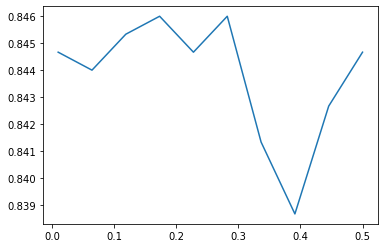

0.846 0.17333333333333334


In [159]:
irange = np.linspace(0.01, 0.5, 10)
score_list = []

for i in irange:
    clf = SVC(kernel="linear", gamma="auto", cache_size=5000, class_weight={1: 1 + i}).fit(Xtrain, Ytrain)
    result = clf.predict(Xtest)
    score = clf.score(Xtest, Ytest)  # 计算accuracy
    score_list.append(score)
plt.plot(irange, score_list)
plt.show()
print(max(score_list), irange[score_list.index(max(score_list))])

惊喜出现了，我们的最高准确度是84.60%，超过了我们之前什么都不做的时候得到的84.40%。可见，模型还是有潜力的。我们可以继续细化我们的学习曲线来进行调整：

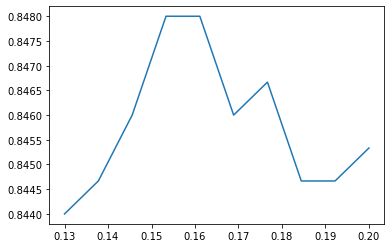

0.848 0.15333333333333335


In [160]:
irange = np.linspace(0.13, 0.2, 10)
score_list = []

for i in irange:
    clf = SVC(kernel="linear", gamma="auto", cache_size=5000
              , class_weight={1: 1 + i}
              ).fit(Xtrain, Ytrain)
    result = clf.predict(Xtest)
    score = clf.score(Xtest, Ytest)  # 计算accuracy
    score_list.append(score)
plt.plot(irange, score_list)
plt.show()
print(max(score_list), irange[score_list.index(max(score_list))])

模型的效果并没有提升许多。可见，模型在不做样本平衡的情况下，准确度其实已经非常接近极限了，让模型向着少数类的方向调节，不能够达到质变。如果我们真的希望再提升准确度，只能选择更换模型的方式，调整参数已经不能够帮助我们了。想想看什么模型在线性数据上表现最好呢？

In [167]:
logclf = LogisticRegression(solver="liblinear").fit(Xtrain, Ytrain)
logclf.score(Xtest, Ytest)  # 84.87%

# 调整参数
C_range = np.linspace(1, 3, 10)
for C in C_range:
    logclf = LogisticRegression(solver="liblinear", C=C).fit(Xtrain, Ytrain)
    print(C, logclf.score(Xtest, Ytest))  # 0.85

1.0 0.8486666666666667
1.2222222222222223 0.8486666666666667
1.4444444444444444 0.85
1.6666666666666665 0.8493333333333334
1.8888888888888888 0.8493333333333334
2.111111111111111 0.8493333333333334
2.333333333333333 0.8486666666666667
2.5555555555555554 0.8493333333333334
2.7777777777777777 0.8493333333333334
3.0 0.8493333333333334


尽管我们实现了非常小的提升，但可以看出来，模型的精确度还是没有能够实现质变。也许，要将模型的精确度提升到90%以上，我们需要集成算法：比如，梯度提升树。大家如果感兴趣，可以自己下去试试看。
## 5.3 追求平衡
我们前面经历了多种尝试，选定了线性核，并发现调节class_weight并不能够使我们模型有较大的改善。现在我们来试试看调节线性核函数的C值能否有效果：

When C is 0.01, accuracy is 0.8; recall is 0.7521865889212828; auc is 0.8706340666900172; 
Using time 00:00:744523
When C is 0.23111111111111113, accuracy is 0.7953333333333333; recall is 0.7784256559766763; auc is 0.8702586109144238; 
Using time 00:01:493169
When C is 0.45222222222222225, accuracy is 0.796; recall is 0.7813411078717201; auc is 0.8697571632678258; 
Using time 00:02:247365
When C is 0.6733333333333333, accuracy is 0.796; recall is 0.7755102040816326; auc is 0.8699209527001319; 
Using time 00:03:362053
When C is 0.8944444444444445, accuracy is 0.796; recall is 0.7755102040816326; auc is 0.8700545040833966; 
Using time 00:03:890951
When C is 1.1155555555555556, accuracy is 0.796; recall is 0.7755102040816326; auc is 0.8700469445711363; 
Using time 00:04:549749
When C is 1.3366666666666667, accuracy is 0.796; recall is 0.7755102040816326; auc is 0.870014186684675; 
Using time 00:05:568682
When C is 1.557777777777778, accuracy is 0.796; recall is 0.7755102040816326; auc is 

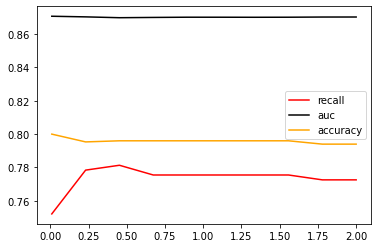

In [171]:
C_range = np.linspace(0.01, 2, 10)

recallall = []
aucall = []
scoreall = []

for C in C_range:
    times = time()
    clf = SVC(kernel="linear", C=C, cache_size=10000, class_weight="balanced").fit(Xtrain, Ytrain)
    result = clf.predict(Xtest)
    score = clf.score(Xtest, Ytest)
    recall = recall_score(Ytest, result)
    auc = roc_auc_score(Ytest, clf.decision_function(Xtest))
    recallall.append(recall)
    aucall.append(auc)
    scoreall.append(score)
    print("When C is {}, accuracy is {}; recall is {}; auc is {}; ".format(C, score, recall, auc))
    print("Using time {}".format(datetime.datetime.fromtimestamp(time() - times).strftime("%M:%S:%f")))

print(max(aucall), C_range[aucall.index(max(aucall))])
plt.figure()
plt.plot(C_range, recallall, c="red", label="recall")
plt.plot(C_range, aucall, c="black", label="auc")
plt.plot(C_range, scoreall, c="orange", label="accuracy")
plt.legend()
plt.show()

可以观察到几个现象。

首先，我们注意到，随着C值逐渐增大，模型的运行速度变得越来越慢。对于SVM这个本来运行就不快的模型来说，巨大的C值会是一个比较危险的消耗。所以正常来说，我们应该设定一个较小的C值范围来进行调整。

其次，C很小的时候，模型的各项指标都很低，但当C到1以上之后，模型的表现开始逐渐稳定，在C逐渐变大之后，模型的效果并没有显著地提高。可以认为我们设定的C值范围太大了，然而再继续增大或者缩小C值的范围，AUC面积也只能够在0.87上下进行变化了，调节C值不能够让模型的任何指标实现质变。

我们把目前为止最佳的C值带入模型，看看我们的准确率，Recall的具体值：

In [172]:
times = time()
clf = SVC(kernel="linear", C=0.01, cache_size=5000, class_weight="balanced").fit(Xtrain, Ytrain)
result = clf.predict(Xtest)
score = clf.score(Xtest, Ytest)
recall = recall_score(Ytest, result)
auc = roc_auc_score(Ytest, clf.decision_function(Xtest))
print("testing accuracy %f,recall is %f', auc is %f" % (score, recall, auc))
print(datetime.datetime.fromtimestamp(time() - times).strftime("%M:%S:%f"))

testing accuracy 0.800000,recall is 0.752187', auc is 0.870634
00:00:698066


可以看到，这种情况下模型的准确率，Recall和AUC都没有太差，但是也没有太好，这也许就是模型平衡后的一种结果。现在，光是调整支持向量机本身的参数，已经不能够满足我们的需求了，要想让AUC面积更进一步，我们需要绘制ROC曲线，查看我们是否可以通过调整阈值来对这个模型进行改进。

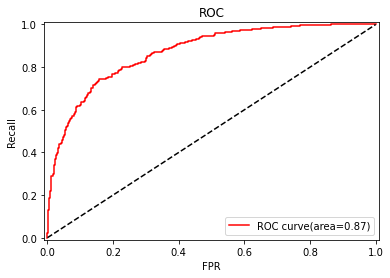

In [179]:
FPR, Recall, thresholds = roc_curve(Ytest, clf.decision_function(Xtest), pos_label=1)
area = roc_auc_score(Ytest, clf.decision_function(Xtest))

plt.figure()
plt.plot(FPR, Recall, color="red", label="ROC curve(area=%0.2f)" % area)
plt.plot([0, 1], [0, 1], color="black", linestyle="--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("FPR")
plt.ylabel("Recall")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()

以此模型作为基础，我们来求解最佳阈值：

In [180]:
maxindex = (Recall - FPR).tolist().index(max(Recall - FPR))
thresholds[maxindex]

0.13157937002697184

基于我们选出的最佳阈值，我们来人为确定y_predict，并确定在这个阈值下的recall和准确度的值：

In [187]:
times = time()
clf = SVC(kernel="linear", C=0.01, cache_size=5000, class_weight="balanced").fit(Xtrain, Ytrain)
prob = pd.DataFrame(clf.decision_function(Xtest))

prob.loc[prob[0] >= thresholds[maxindex], "y_pred"] = 1
prob.loc[prob[0] < thresholds[maxindex], "y_pred"] = 0

prob.loc[:, "y_pred"].isnull().sum()

# 检验模型本身的准确度
score = accuracy_score(Ytest, prob.loc[:, "y_pred"].values)
recall = recall_score(Ytest, prob.loc[:, "y_pred"])
print("The accuracy score is %f, the recall score is %f" % (score, recall))
print(datetime.datetime.fromtimestamp(time() - times).strftime("%M:%S:%f"))

The accuracy score is 0.820667, the recall score is 0.743440
00:00:554349


可见，如果我们追求平衡，那SVC本身的结果就已经非常接近最优结果了。调节阈值，调节参数C和调节class_weight都不一定有效果。但整体来看，我们的模型不是一个糟糕的模型，但这个结果如果提交到kaggle参加比赛是绝对不足够的。如果大家感兴趣，还可以更加深入地探索模型，或者换别的方法来处理特征，以达到AUC面积0.9以上，或是准确度或recall都提升到90%以上。